# Modern portfolio theory of H. Markowitz

Modern portfolio theory is a practical method of selecting investments to maximise their overall return within an acceptable level of risk. This mathematical framework is used to construct a portfolio of investments that maximises the amount of expected return for a given level of collective risk — portfolio risk.

A key element of the LMP is diversification. Most investments are either high risk/high return or low risk/low return. According to Markowitz, investors can achieve the best results by choosing an optimal combination of these two types of investments based on an assessment of their individual risk tolerance.

In portfolio optimization we have some amount of money to invest in any of $n$ different assets. <br>
We choose what fraction $w_i$ of our money to invest in each asset $i$, $i=1, \ldots, n$.<br>
We call $w\in {\bf R}^n$ the **_portfolio allocation vector_**.<br>
We of course have the constraint that ${\mathbf 1}^T w =1$.
The allocation $w_i<0$ means a **short position** in asset $i$, or that we borrow shares to sell now that we must replace later.
The allocation $w \geq 0$ is a _long only_ portfolio.
The quantity
$$ \|w \|_1 = {\mathbf 1}^T w_+ + {\mathbf 1}^T w\_- $$
is known as _leverage_.

- Expected return: $$\mathbb{E}(r_p)=w^T\space \mathbb{E}(r) = \sum^{n}_{i=1}w_i\mathbb{E}(r_i)$$
- Risk (Annualized volatility $\sigma$ ) : $$\sigma^2_p=\sum^{n}_{i=1}\sum^{n}_{j=1}w_i\times w_j\times cov(r_i,r_j)$$
- The Sharpe Ratio from the CAPM: $$S_p=\frac{\mathbb{E}(r_p-r_f)}{\sigma_p}\space\text{basically}\space S_p=\frac{\mathbb{E}(r_p)-r_{f_{annualized}}}{\sigma_p}$$


In [1]:
from warnings import filterwarnings

filterwarnings("ignore")
from datetime import datetime
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
from modules.data_fetcher import (
    download_historical_data,
    get_list_of_symbols,
    build_close_df,
)
from modules.stock_symbols import (
    get_cac40_symbols,
    get_largest_symbols_by_country_normal,
)
from modules.portfolio_optimization import (
    MonteCarloPortfolio,
    ConvexPortfolio,
    RiskParityPortfolio,
)

In [5]:
MININUM_HISTORY_YEAR = 2
N = 365
# get_list_of_symbols()
symbols = set(
    [
        "ROSE-USDT",
        "AVAX-USDT",
        "UNI-USDT",
        "ATOM-USDT",
        "ICP-USDT",
        "THETA-USDT",
        "VET-USDT",
        "DOGE3S-USDT",
        "BNB-USDT",
        "NEAR-BTC",
        "BTC-USDT",
        "NEAR-USDT",
        "SOLVE-BTC",
        "ETH-USDT",
        "KDA-USDT",
        "SOL-USDT",
        "EGLD-USDT",
        "ALGO-USDT",
        "FTM-USDT",
        "AXS-USDT",
        "ADA-USDT",
        "NKN-USDT",
        "LOOM-BTC",
        "CUSD-USDT",
        "LTC3L-USDT",
        "XPR-USDT",
    ]
)


closes = build_close_df(symbols)

cols_to_remove = [
    col
    for col, nans in closes.isna().sum().items()
    if len(closes) - nans < N * MININUM_HISTORY_YEAR
]


closes.drop(columns=cols_to_remove, inplace=True)
returns = closes.pct_change().dropna()
log_returns = np.log(closes).pct_change().dropna()
returns.head()

,SOLVE-BTC_Close,ALGO-USDT_Close,THETA-USDT_Close,FTM-USDT_Close,LOOM-BTC_Close,AVAX-USDT_Close,VET-USDT_Close,UNI-USDT_Close,ROSE-USDT_Close,ETH-USDT_Close,BTC-USDT_Close,ADA-USDT_Close,BNB-USDT_Close,ATOM-USDT_Close
Date,,,,,,,,,,,,,,
2021-03-18,0.285714,-0.024277,0.071096,-0.066114,0.210909,0.015400,0.011595,-0.041741,-0.113455,-0.025642,-0.020839,-0.110428,-0.031226,0.056637
2021-03-19,0.000000,-0.007790,-0.022681,0.039372,-0.063063,0.123951,0.043658,0.110345,-0.035220,0.018789,0.006510,0.053323,0.006515,0.005138
2021-03-20,-0.146538,-0.032927,0.012084,0.030256,-0.019231,-0.084177,0.105900,-0.039371,-0.002097,-0.001780,0.001539,-0.072942,0.004986,-0.059096
2021-03-21,0.056604,-0.021953,0.151563,-0.000211,0.006536,-0.042039,0.046807,0.026449,0.167348,-0.012690,-0.013135,-0.011763,0.001433,-0.018490
2021-03-22,-0.028571,-0.066576,0.044366,-0.074746,0.061688,-0.107483,-0.057433,-0.000113,-0.136010,-0.057339,-0.056741,-0.071503,-0.036593,-0.065317


100%|██████████| 20000/20000 [00:18<00:00, 1100.43it/s]


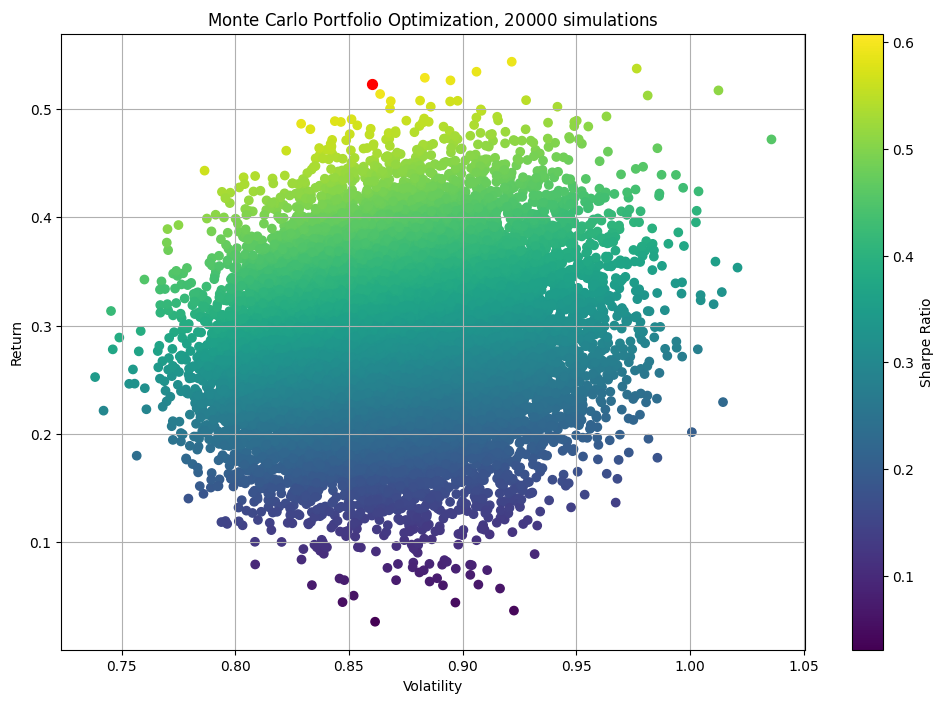

--------------  Results  ---------------
- Annualized Sharpe ratio: 0.61
- Annualized risk (volatility): 86.03 %
- Annualized expected return: 52.27 %


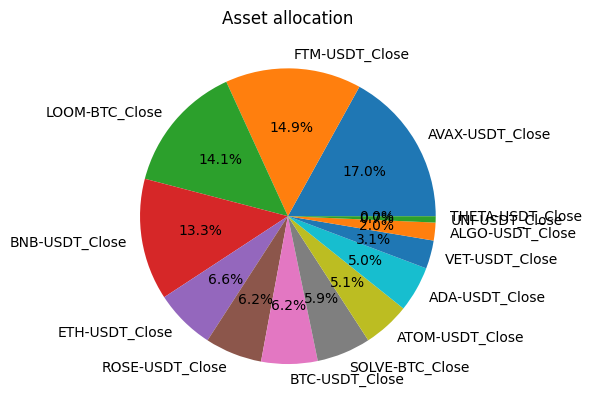

,ADA-USDT_Close,ETH-USDT_Close,FTM-USDT_Close,ALGO-USDT_Close,VET-USDT_Close,BNB-USDT_Close,AVAX-USDT_Close,SOLVE-BTC_Close,UNI-USDT_Close,LOOM-BTC_Close,BTC-USDT_Close,ROSE-USDT_Close,THETA-USDT_Close,ATOM-USDT_Close
0,0.049908,0.066282,0.148765,0.019537,0.030953,0.133042,0.169631,0.058992,0.006854,0.140865,0.06156,0.062331,0.000029,0.051251


In [3]:
portfolio = MonteCarloPortfolio(returns)


portfolio.fit(n_portfolios=20000, plot=True)
portfolio.get_allocation("sharpe", "max")

# Convex process


--------------  Results  ---------------
- Annualized Sharpe ratio: 0.81
- Annualized risk (volatility): 82.26 %
- Annualized expected return: 66.44 %


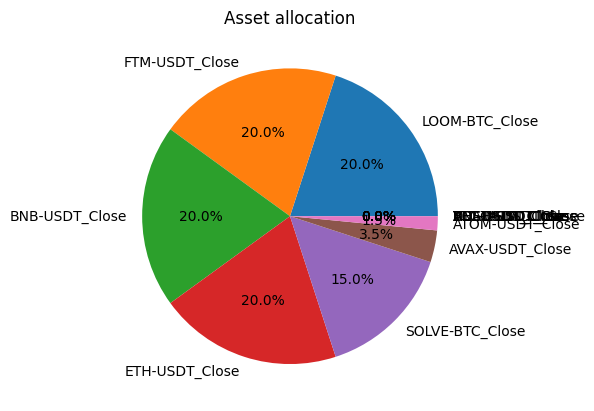

,ADA-USDT_Close,ETH-USDT_Close,FTM-USDT_Close,ALGO-USDT_Close,VET-USDT_Close,BNB-USDT_Close,AVAX-USDT_Close,SOLVE-BTC_Close,UNI-USDT_Close,LOOM-BTC_Close,BTC-USDT_Close,ROSE-USDT_Close,THETA-USDT_Close,ATOM-USDT_Close
0,2.796017e-16,0.2,0.2,9.990682e-17,0.0,0.2,0.034824,0.14979,1.037058e-16,0.2,9.619583e-17,1.629823e-16,5.570229e-16,0.015386


In [11]:
ptf = ConvexPortfolio(returns)
ptf.fit("sharpe", "max", max_asset_weight=0.2)
ptf.get_allocation()

--------------  Results  ---------------
- Annualized Sharpe ratio: 0.35
- Annualized risk (volatility): 79.82 %
- Annualized expected return: 27.87 %


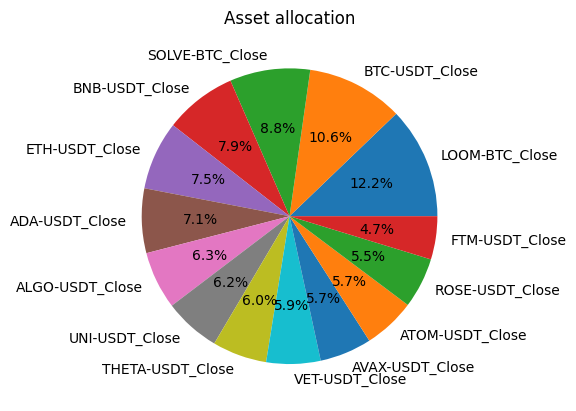

,ADA-USDT_Close,ETH-USDT_Close,FTM-USDT_Close,ALGO-USDT_Close,VET-USDT_Close,BNB-USDT_Close,AVAX-USDT_Close,SOLVE-BTC_Close,UNI-USDT_Close,LOOM-BTC_Close,BTC-USDT_Close,ROSE-USDT_Close,THETA-USDT_Close,ATOM-USDT_Close
0,0.070543,0.075219,0.047225,0.063173,0.059258,0.079027,0.056854,0.087886,0.061564,0.121798,0.105788,0.055237,0.059612,0.056815


In [12]:
rp_ptf = RiskParityPortfolio(returns)
rp_ptf.fit()
rp_ptf.get_allocation()

## CAC40


In [2]:
import yfinance as yf

cac40_data = yf.download(get_cac40_symbols(), start="2013-01-01", end="2023-03-01")[
    "Adj Close"
]
returns = cac40_data.fillna(method="ffill").pct_change().dropna()
returns

[*********************100%***********************]  40 of 40 completed


,ACA.PA,AI.PA,AIR.PA,ALO.PA,BN.PA,BNP.PA,CA.PA,CAP.PA,CS.PA,DG.PA,...,SNY,STLA,STM,SU.PA,TEP.PA,TTE,URW.AS,VIE.PA,VIV.PA,WLN.PA
Date,,,,,,,,,,,,,,,,,,,,,
2014-06-30,-0.028302,0.012009,-0.007101,-0.007086,-0.004771,0.002732,-0.008100,-0.007241,-0.003141,-0.007994,...,-0.002626,-0.018812,-0.012222,-0.004921,0.010271,0.000000,-0.000706,-0.023166,-0.008049,0.012195
2014-07-01,0.029612,0.010953,-0.020331,-0.011080,0.015671,0.036028,0.013920,0.010556,0.006875,-0.002930,...,0.002069,0.035318,0.046119,-0.001018,0.010613,0.007895,0.003060,0.015091,0.014829,-0.012048
2014-07-02,-0.004243,-0.000802,-0.013661,-0.013673,-0.003812,-0.006234,0.020501,0.004368,0.000853,-0.001286,...,-0.001501,-0.009746,-0.003226,-0.009901,0.020451,-0.006184,-0.003754,-0.029026,-0.010201,-0.006098
2014-07-03,0.013731,0.015060,0.010044,0.004043,0.015306,0.004705,0.003049,0.054085,0.031836,-0.002943,...,0.004699,0.033465,0.007551,0.021029,0.010833,-0.003042,-0.001413,-0.001094,0.017827,0.006135
2014-07-04,-0.006072,0.004946,0.004396,0.008629,-0.004846,-0.020488,-0.007689,-0.017582,-0.002479,-0.002214,...,0.000000,0.000000,0.000000,-0.001729,0.006216,0.000000,-0.010377,-0.001825,-0.006568,-0.003049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,-0.020138,-0.008614,-0.000326,-0.003332,0.044924,-0.022018,-0.012111,-0.011813,-0.010672,0.002204,...,0.008824,0.036615,-0.005880,0.004313,-0.021974,-0.014514,-0.022595,-0.005614,-0.004883,-0.018196
2023-02-23,0.007729,-0.006951,0.013520,0.000371,-0.013904,0.012977,-0.009473,0.006394,0.032362,-0.012828,...,0.006039,0.043428,0.022391,0.004945,0.007489,0.024761,0.033275,0.002823,-0.003067,0.010296
2023-02-24,-0.010807,-0.005653,-0.020090,0.018938,-0.002412,-0.013891,0.027286,-0.027901,-0.010449,-0.019491,...,-0.012627,-0.024972,-0.019422,-0.035349,-0.021518,-0.011371,-0.012034,-0.002815,-0.004717,-0.038471


--------------  Results  ---------------
- Annualized Sharpe ratio: 1.47
- Annualized risk (volatility): 23.49 %
- Annualized expected return: 34.59 %


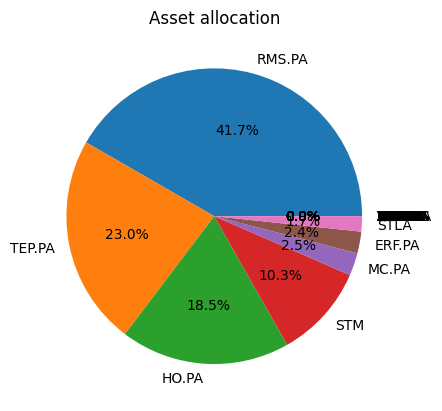

,ACA.PA,AI.PA,AIR.PA,ALO.PA,BN.PA,BNP.PA,CA.PA,CAP.PA,CS.PA,DG.PA,...,SNY,STLA,STM,SU.PA,TEP.PA,TTE,URW.AS,VIE.PA,VIV.PA,WLN.PA
0,5.323077e-17,0.0,0.0,0.0,0.0,0.0,1.428969e-16,0.0,0.0,0.0,...,0.0,0.016697,0.102772,1.731868e-16,0.229957,0.0,1.409475e-15,0.0,3.577463e-17,0.0


In [15]:
ptf = ConvexPortfolio(returns)
ptf.fit("sharpe", "max", max_asset_weight=0.6)
ptf.get_allocation()

# Risk parity optimization


--------------  Results  ---------------
- Annualized Sharpe ratio: 0.85
- Annualized risk (volatility): 21.95 %
- Annualized expected return: 18.66 %


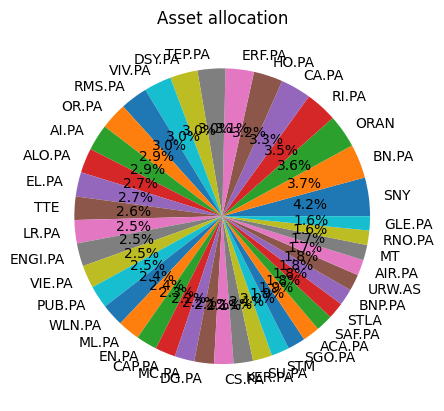

,ACA.PA,AI.PA,AIR.PA,ALO.PA,BN.PA,BNP.PA,CA.PA,CAP.PA,CS.PA,DG.PA,...,SNY,STLA,STM,SU.PA,TEP.PA,TTE,URW.AS,VIE.PA,VIV.PA,WLN.PA
0,0.018669,0.028795,0.017217,0.026927,0.037194,0.018068,0.033369,0.022143,0.021225,0.021396,...,0.042183,0.018114,0.019671,0.021029,0.030463,0.025517,0.017969,0.024986,0.029998,0.024499


In [7]:
rp_ptf = RiskParityPortfolio(returns)
rp_ptf.fit()
rp_ptf.get_allocation()

# Genetic algo

In [ ]:

import numpy as np

# Define the fitness function to maximize the Sharpe Ratio
def fitness_function(weights, data):
    data_returns = np.log(data) - np.log(data.shift(1))
    data_returns = data_returns.dropna()
    
    portfolio_returns = np.dot(data_returns, weights)
    portfolio_mean = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)
    sharpe_ratio = (portfolio_mean / portfolio_std) * np.sqrt(252)
    return sharpe_ratio

# Define the genetic algorithm
def genetic_algorithm(data, population_size=200, num_generations=50, mutation_rate=0.05, elitism=0.1):
    # Initialize the population
    population = np.random.rand(population_size, len(data.columns))
    population = population / np.sum(population, axis=1)[:, np.newaxis]

    # Calculate fitness of initial population
    fitness = np.array([fitness_function(individual, data) for individual in population])
    
    for generation in range(num_generations):
        # Sort the population by fitness
        sorted_idx = np.argsort(fitness)[::-1]
        population = population[sorted_idx]
        fitness = fitness[sorted_idx]
        
        # Determine number of individuals to carry over via elitism
        num_elites = int(elitism * population_size)
        
        # Create the next generation, starting with the elites
        offspring = population[:num_elites]
        
        # Select parents for reproduction using tournament selection
        parent1_idx = np.random.randint(num_elites, population_size, size=population_size-num_elites)
        parent2_idx = np.random.randint(num_elites, population_size, size=population_size-num_elites)
        parent1 = population[parent1_idx]
        parent2 = population[parent2_idx]

        # Perform crossover and mutation to create the next generation
        crossover_prob = np.random.rand(population_size-num_elites, len(data.columns))
        crossover_mask = crossover_prob <= 0.5
        offspring_crossover = np.where(crossover_mask, parent1, parent2)

        mutation_prob = np.random.rand(population_size-num_elites, len(data.columns))
        mutation_mask = mutation_prob <= mutation_rate
        mutation_values = np.random.rand(population_size-num_elites, len(data.columns))
        mutation_direction = np.random.choice([-1, 1], size=(population_size-num_elites, len(data.columns)))
        offspring_mutation = np.where(mutation_mask, offspring_crossover + mutation_direction * mutation_values, offspring_crossover)

        # Ensure the offspring population has valid weights
        offspring_mutation = offspring_mutation / np.sum(offspring_mutation, axis=1)[:, np.newaxis]

        # Combine elites and offspring to create the next generation
        population = np.vstack((population[:num_elites], offspring_mutation))
        
        # Calculate fitness of new population
        fitness = np.array([fitness_function(individual, data) for individual in population])
        
    # Return the best individual from the final population
    best_idx = np.argmax(fitness)
    best_individual = population[best_idx]
    print('Best Sharpe Ratio: ', np.max(fitness)) 

    return best_individual

from datetime import datetime, timedelta

# Seed for reproducibility
np.random.seed(42)

def backtest(genetic_algorithm, data, benchmark, initial_capital):
    # Split the data into training and testing sets
    train_data = data.iloc[:-252]
    test_data = data.iloc[-252:]

    # Run the genetic algorithm on the training set to find the optimal portfolio weights
    weights = genetic_algorithm(data=train_data, population_size=100, num_generations=50, mutation_rate=0.01, elitism=0.01)
    # print(weights)

    # Set any negative weights to 0
    weights[weights < 0] = 0

    # Normalize remaining positive weights to sum to 1
    weights /= weights.sum()

    # Calculate the returns of the portfolio and the benchmark on the test set
    portfolio_returns = np.dot(test_data.pct_change().dropna(), weights)
    portfolio_cum_returns = np.cumprod(1 + portfolio_returns)
    portfolio_value = initial_capital * portfolio_cum_returns[-1]
    benchmark_returns = benchmark.iloc[-252:].pct_change().dropna()
    benchmark_cum_returns = np.cumprod(1 + benchmark_returns)
    benchmark_value = initial_capital * benchmark_cum_returns[-1]

    # Calculate performance metrics
    portfolio_mean_return = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)
    portfolio_sharpe_ratio = (portfolio_mean_return / portfolio_std) * np.sqrt(252)
    benchmark_mean_return = np.mean(benchmark_returns)
    benchmark_std = np.std(benchmark_returns)
    benchmark_sharpe_ratio = (benchmark_mean_return / benchmark_std) * np.sqrt(252)

    # print(portfolio_cum_returns)

    # Visualize the performance of the portfolio and the benchmark
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(benchmark_cum_returns.index, portfolio_cum_returns, label='Portfolio')
    ax.plot(benchmark_cum_returns, label='Benchmark')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Returns')
    ax.set_title('Backtesting Results')
    ax.legend()
    plt.show()

    # Print performance metrics
    print('Portfolio Statistics:')
    print('---------------------')
    print('Mean Daily Return: {:.4f}'.format(portfolio_mean_return))
    print('Standard Deviation: {:.4f}'.format(portfolio_std))
    print('Sharpe Ratio: {:.4f}'.format(portfolio_sharpe_ratio))
    print('Final Value: {:.2f}'.format(portfolio_value))
    print('')
    print('Benchmark Statistics:')
    print('---------------------')
    print('Mean Daily Return: {:.4f}'.format(benchmark_mean_return))
    print('Standard Deviation: {:.4f}'.format(benchmark_std))
    print('Sharpe Ratio: {:.4f}'.format(benchmark_sharpe_ratio))
    print('Final Value: {:.2f}'.format(benchmark_value))
    
    return portfolio_returns, benchmark_returns, portfolio_cum_returns, benchmark_cum_returns
    
portfolio_returns, benchmark_returns, portfolio_cum_returns, benchmark_cum_returns = backtest(genetic_algorithm, data, benchmark, initial_capital=1000)

# Using Riskfolio


In [16]:
import riskfolio as rp

port = rp.Portfolio(returns=returns)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu = "hist"  # Method to estimate expected returns based on historical data.
method_cov = "hist"  # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model = "Classic"  # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = "MV"  # Risk measure used, this time will be variance
obj = "Sharpe"  # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True  # Use historical scenarios for risk measures that depend on scenarios
rf = 0  # Risk free rate
l = 0  # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,ACA.PA,AI.PA,AIR.PA,ALO.PA,BN.PA,BNP.PA,CA.PA,CAP.PA,CS.PA,DG.PA,...,SNY,STLA,STM,SU.PA,TEP.PA,TTE,URW.AS,VIE.PA,VIV.PA,WLN.PA
weights,1.067000e-09,2.679894e-09,1.211747e-09,1.111103e-09,1.600355e-09,1.437620e-09,1.164322e-09,2.572792e-09,2.918250e-09,1.673239e-09,...,2.124870e-09,0.016689,0.102779,1.438078e-09,0.229963,1.627762e-09,4.344084e-10,3.195521e-09,9.722353e-10,1.833684e-09


<Axes: title={'center': 'Sharpe Mean Variance'}>

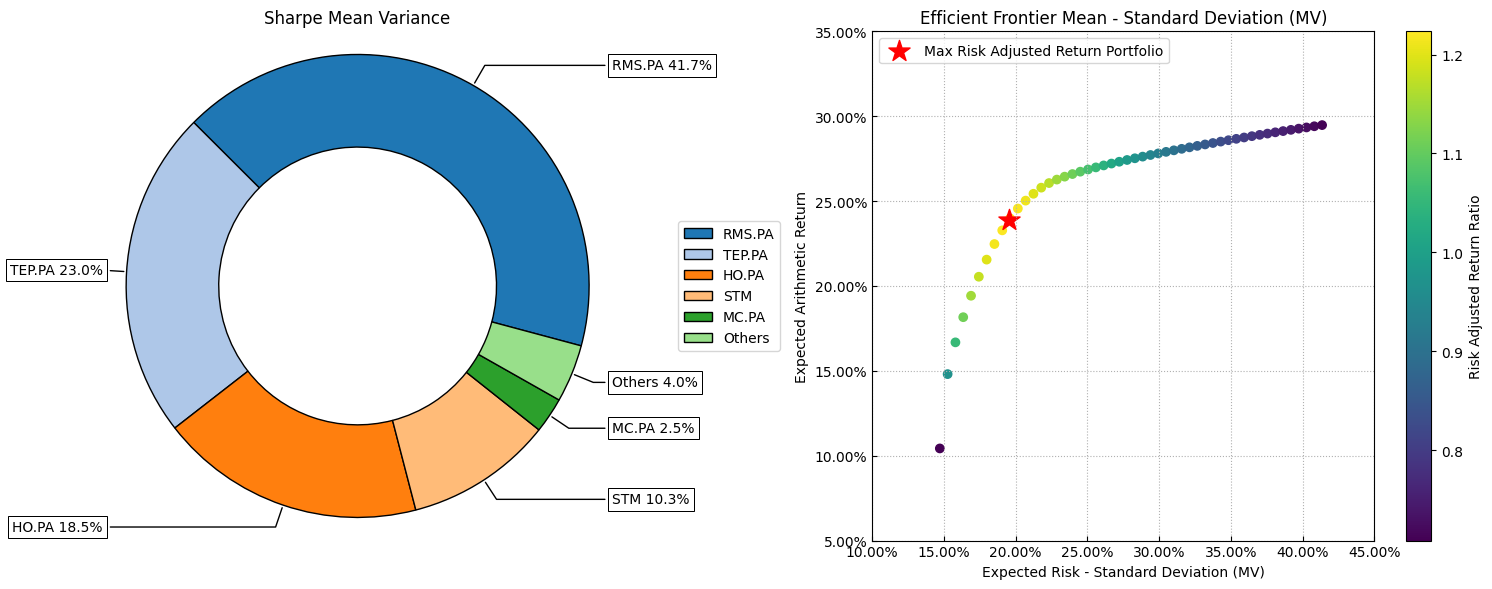

In [17]:
points = 50  # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)


label = "Max Risk Adjusted Return Portfolio"  # Title of point
mu = port.mu  # Expected returns
cov = port.cov  # Covariance matrix
returns = port.returns  # Returns of the assets

figure, ax = plt.subplots(1, 2, figsize=(15, 6))


rp.plot_frontier(
    w_frontier=frontier,
    mu=mu,
    cov=cov,
    returns=returns,
    rm=rm,
    rf=rf,
    alpha=0.05,
    cmap="viridis",
    w=w,
    label=label,
    marker="*",
    s=16,
    c="r",
    height=6,
    width=10,
    ax=ax[1],
)


rp.plot_pie(
    w=w,
    title="Sharpe Mean Variance",
    others=0.05,
    nrow=25,
    cmap="tab20",
    height=6,
    width=10,
    ax=ax[0],
)

In [51]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.
rms = [
    "MV",
    "MAD",
    "MSV",
    "FLPM",
    "SLPM",
    "CVaR",
    "EVaR",
    "WR",
    "MDD",
    "ADD",
    "CDaR",
    "UCI",
    "EDaR",
]

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)

w_s.columns = rms


def filter_unused(x: pd.Series):
    for i in x:
        if i >= 1e-3:
            return True
    return False


w_s = w_s.loc[w_s.apply(filter_unused, axis=1)]
w_s.style.format("{:.2%}").background_gradient(cmap="YlGn")

Failure:interrupted
The problem doesn't have a solution with actual input parameters


## Comparing each portfolio


<Axes: >

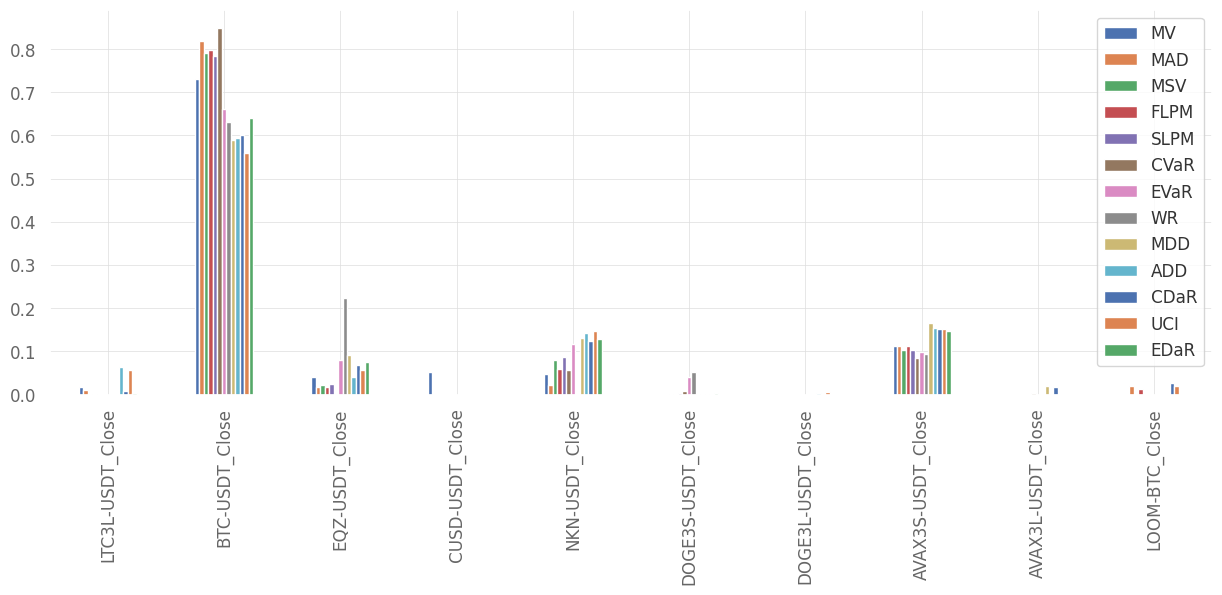

In [ ]:
fig = plt.gcf()
fig.set_figwidth(15)
fig.set_figheight(5)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

# Using empyrical


In [ ]:
from empyrial import empyrial, Engine

portfolio = Engine(
    start_date="2018-01-01",  # start date for the backtesting
    portfolio=[
        "IRCTC.NS",
        "RELIANCE.NS",
        "INFY.NS",
        "HDFCBANK.NS",
    ],  # assets in your portfolio
    weights=[0.2, 0.2, 0.2, 0.2],  # equal weighting is set by default
    benchmark=["^NSEI"],  # SPY is set by default
)

empyrial(portfolio)